<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

# 2021 NASA Harvest Rwanda Baseline Model

This notebook walks you through the steps to create a baseline field delineation model for detecting boundaries from sentinel-2 time-series satellite imagery using a spatio-temporal U-Net model on the 2021 NASA Harvest dataset.

### Dependencies

All the dependencies for this notebook to run on colab are included in the `requirements_colab.txt` file included in this folder. To run the model on GPU you should go to edit/notebook settings and select GPU

In [1]:
!pip install -r 'https://raw.githubusercontent.com/radiantearth/Nasa_harvest_field_boundary_competition/main/requirements_colab.txt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 489.6 MB 26 kB/s 
     |████████████████████████████████| 20.9 MB 106.6 MB/s 
     |████████████████████████████████| 2.9 MB 59.0 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 146 kB 76.5 MB/s 
     |████████████████████████████████| 1.3 MB 55.9 MB/s 
     |████████████████████████████████| 463 kB 68.9 MB/s 
     |████████████████████████████████| 50 kB 8.3 MB/s 
     |████████████████████████████████| 1.6 MB 54.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow-estimator
    Found existing installati

In [2]:
# Importing the needed libraries
import getpass
import glob
import keras
import os
import pickle
import random
import shutil
from radiant_mlhub import Dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio

import tensorflow as tf
import segmentation_models as sm

from pathlib import Path
from radiant_mlhub import Dataset
from random import choice
from segmentation_models import Unet
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split


from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.models import load_model
from keras.optimizers import *
from keras.preprocessing import image

from tensorflow.keras.layers import *
from tensorflow.keras.losses import *

from sklearn.model_selection import train_test_split

from typing import List, Any, Callable, Tuple

import cv2
import math

Segmentation Models: using `keras` framework.


In [3]:
dataset_id = 'nasa_rwanda_field_boundary_competition'
assets = ['labels']

In [4]:
#Append your MLHUB_API_KEY after this cell is executed to download dataset
os.environ['MLHUB_API_KEY'] =  getpass.getpass(prompt="MLHub API Key: ")
dataset = Dataset.fetch(dataset_id)

MLHub API Key: ··········


In [5]:
dataset.download(output_dir = dataset_id, if_exists='overwrite')

  0%|          | 0/0.4 [00:00<?, ?M/s]

  0%|          | 0/112.5 [00:00<?, ?M/s]

  0%|          | 0/25.5 [00:00<?, ?M/s]

[PosixPath('/content/nasa_rwanda_field_boundary_competition/nasa_rwanda_field_boundary_competition_labels_train.tar.gz'),
 PosixPath('/content/nasa_rwanda_field_boundary_competition/nasa_rwanda_field_boundary_competition_source_train.tar.gz'),
 PosixPath('/content/nasa_rwanda_field_boundary_competition/nasa_rwanda_field_boundary_competition_source_test.tar.gz')]

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
archives = ['source_train', 'source_test', 'labels_train']

In [8]:
for archive in archives:
  full_path = f"{dataset_id}/{dataset_id}_{archive}.tar.gz"
  shutil.unpack_archive(full_path, dataset_id)

In [9]:
#image snapshot dimensions
IMG_WIDTH = 256 
IMG_HEIGHT = 256 
IMG_CHANNELS = 4 #we have the rgba bands

We have two sets of data: the train and test dataset, each having a list of file ids belonging to them.
For model development purposes, we will use the training set(`train_tiles`) and use the test set for model prediction/evaluation.

In [10]:
train_source_items = f"{dataset_id}/{dataset_id}_source_train"
train_label_items = f"{dataset_id}/{dataset_id}_labels_train"

In [11]:
next(os.walk(train_source_items))[1][0]

'nasa_rwanda_field_boundary_competition_source_train_27_2021_03'

In [12]:
def clean_string(s: str) -> str:
    """
    extract the tile id and timestamp from a source image folder
    e.g extract 'ID_YYYY_MM' from 'nasa_rwanda_field_boundary_competition_source_train_ID_YYYY_MM'
    """
    s = s.replace(f"{dataset_id}_source_", '').split('_')[1:]
    return '_'.join(s)

In [13]:
train_tiles = [clean_string(s) for s in next(os.walk(train_source_items))[1]]

Our source images have pixel values > 255, hence we need to apply normalisation on our images to generate a normalised image. We apply the min-max normalisation for this which is simply: $${\text{all pixel values - minimum pixel value} \over \text{maximum pixel value - minimum pixel value}}$$

In [14]:
def normalize(
    array: np.ndarray
):
    """ normalise image to give a meaningful output """
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

### Data Augmentation

In this notebook, we will perform data augmentation on our normalised images. This will be used to populate the model with data to obtain even more accurate results.

We will employ the following data augmentation techniques on the dataset:
- rotation, flipping, blurring.

These techniques were thanks to the radix-ai GitHub repository, which can be accessed [here](https://github.com/radix-ai/agoro-field-boundary-detector).
We will observe the results on a random source image and its associated label below:

In [15]:
#loading the 4 bands of the image
tile = random.choice(train_tiles)
print(tile)
bd1 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B01.tif")
bd1_array = bd1.read(1)
bd2 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B02.tif")
bd2_array = bd2.read(1)
bd3 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B03.tif")
bd3_array = bd3.read(1)
bd4 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B04.tif")
bd4_array = bd4.read(1)
b01_norm = normalize(bd1_array)
b02_norm = normalize(bd2_array)
b03_norm = normalize(bd3_array)
b04_norm = normalize(bd4_array)

field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
mask  = rio.open(Path.cwd() / f"{train_label_items}/{dataset_id}_labels_train_{tile.split('_')[0]}/raster_labels.tif").read(1)

14_2021_11


In [16]:
#https://github.com/radix-ai/agoro-field-boundary-detector/tree/master/src/agoro_field_boundary_detector
def t_linear(
    field: np.ndarray,
    mask: np.ndarray,
    _: int = 0,
) -> Tuple[np.ndarray, np.ndarray]:
    """Apply a linear (i.e. no) transformation and save."""
    return field, mask

def t_rotation(
    field: np.ndarray,
    mask: np.ndarray,
    rot: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Rotate the data."""
    assert rot in range(0, 3 + 1)
    for _ in range(rot):
        field = np.rot90(field)
        mask = np.rot90(mask)
    return field, mask

def t_flip(
    field: np.ndarray,
    mask: np.ndarray,
    idx: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Flip the data."""
    assert idx in range(0, 2 + 1)
    if idx == 0:  # Diagonal
        field = np.rot90(np.fliplr(field))
        mask = np.rot90(np.fliplr(mask))
    if idx == 1:  # Horizontal
        field = np.flip(field, axis=0)
        mask = np.flip(mask, axis=0)
    if idx == 2:  # Vertical
        field = np.flip(field, axis=1)
        mask = np.flip(mask, axis=1)
    return field, mask

def t_blur(
    field: np.ndarray,
    mask: np.ndarray,
    sigma: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Blur the image by applying a Gaussian filter."""
    assert 0 <= sigma <= 10
    sigma_f = 1.0 + (sigma / 10)
    field = np.copy(field)
    for i in range(3):
        field[:, :, i] = gaussian_filter(field[:, :, i], sigma=sigma_f)
    return field, mask

def t_gamma(field: np.ndarray,
    mask: np.ndarray)-> Tuple[np.ndarray, np.ndarray]:
    hsv = cv2.cvtColor((field[:,:,0:3]*255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    #hsv = cv2.cvtColor(hsv, cv2.COLOR_RGB2HSV)
    hue, sat, val = cv2.split(hsv)

    # compute gamma = log(mid*255)/log(mean)
    mid = 0.5
    mean = np.mean(val)
    gamma = math.log(mid*255)/math.log(mean)
    #print(gamma)

    # do gamma correction on value channel
    val_gamma = np.power(val, gamma).clip(0,255).astype(np.uint8)

    # combine new value channel with original hue and sat channels
    hsv_gamma = cv2.merge([hue, sat, val_gamma])
    img_gamma2 = cv2.cvtColor(hsv_gamma, cv2.COLOR_HSV2RGB)
    
    return cv2.cvtColor(img_gamma2, cv2.COLOR_RGB2RGBA), mask

def t_rotationAngel(
    field: np.ndarray,
    mask: np.ndarray,
    angel: int,
    ) -> Tuple[np.ndarray, np.ndarray]:
    """Rotate the data."""
    assert 0 <= angel <= 360
    (H, W) = field.shape[:2]
    center = (W/2, H/2)
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angel, scale=np.sqrt(2))
    field = cv2.warpAffine(src=field, M=rotate_matrix, dsize=(W, H),flags=cv2.INTER_NEAREST)
    mask = cv2.warpAffine(src=mask, M=rotate_matrix, dsize=(W, H),flags=cv2.INTER_NEAREST)
    return field, mask



In [17]:
def show_image(field:np.ndarray, mask:np.ndarray): 
    """Show the field and corresponding mask."""
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(121)  # left side
    ax2 = fig.add_subplot(122)  # right side
    ax1.imshow(field[:,:,0:3])  # rgb band
    plt.gray()
    ax2.imshow(mask)
    plt.tight_layout()
    plt.show()

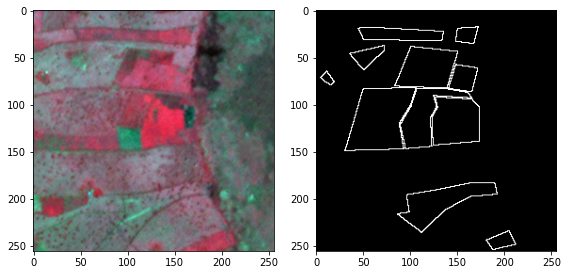

In [18]:
show_image(field, mask)

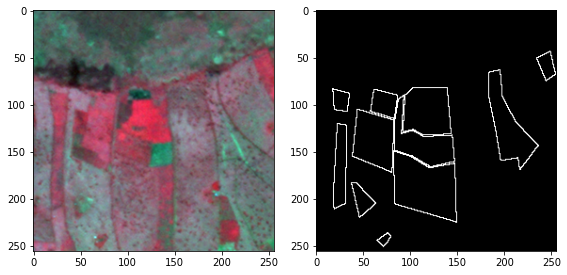

In [19]:
f,m = t_rotation(field, mask, rot=1) #rotation
show_image(f,m)

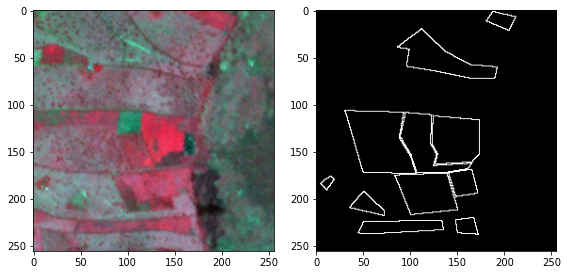

In [20]:
f,m = t_flip(field, mask, idx=1) #flipping
show_image(f,m)

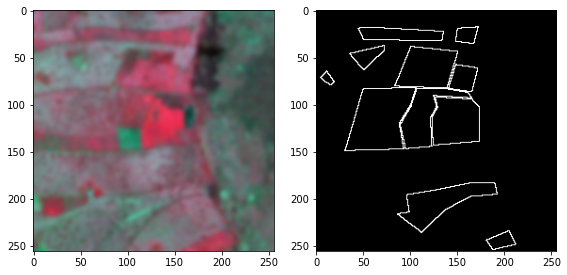

In [21]:
f,m = t_blur(field, mask, sigma=10) #blur
show_image(f,m)

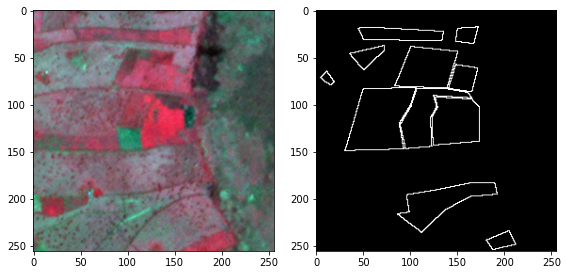

In [22]:
f,m = t_gamma(field, mask) #gamma
show_image(f,m)

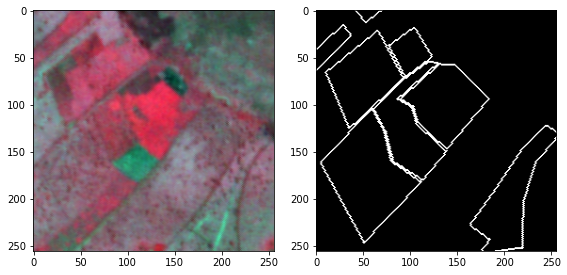

In [23]:
f,m = t_rotationAngel(field, mask,45) #rotate45
show_image(f,m)

In [24]:
def generate(
    field: np.ndarray,
    mask: np.ndarray,
    write_folder: Path,
    prefix: str = "",
) -> None:
    """
    Generate data augmentations of the provided field and corresponding mask which includes:
     - Linear (no) transformation
     - Rotation
     - Horizontal or vertical flip
     - Gaussian filter (blur)
    :param field: Input array of the field to augment
    :param mask: Input array of the corresponding mask to augment
    :param write_folder: Folder (path) to write the results (augmentations) to
    :param prefix: Field-specific prefix used when writing the augmentation results
    """
    # Generate transformations
    f, m = [0,1,2,3,4,5], [0,1,2,3,4,5] #dummy data. will be replaced
    #f[0],m[0] = t_linear(field, mask) #no augmentation #model1 model3
    #f[1],m[1] = t_rotation(field, mask, rot=0) #rotation model3
    #f[2],m[2] = t_rotation(field, mask, rot=1) #rotation #model1 model3
    #f[3],m[3] = t_rotation(field, mask, rot=2) #rotation model3
    #f[4],m[4] = t_rotation(field, mask, rot=3) #rotation model3
    f[0],m[0] = t_flip(field, mask, idx=0) #flipping #model1 #model4
    f[1],m[1] = t_flip(field, mask, idx=1) #rotation #model4
    f[2],m[2] = t_flip(field, mask, idx=2) #rotation #model4
    f[3],m[3] = t_blur(field, mask, sigma=5) #blur #model4
    f[4],m[4] = t_blur(field, mask, sigma=10) #blur #model1 #model4
    f[5],m[5] = t_rotationAngel(field, mask, 45) #rotation #model4
    #f[11],m[11] = t_rotationAngel(field, mask, 135) #rotation
    #f[12],m[12] = t_rotationAngel(field, mask, 225) #rotation
    #f[13],m[13] = t_rotationAngel(field, mask, 315) #rotation
    for i in range(len(f)):        
        with open(write_folder +'/'+ f"fields/{str(prefix).zfill(2)}_{i}.pkl", 'wb') as handle:
            pickle.dump(f[i], handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(write_folder +'/'+ f"masks/{str(prefix).zfill(2)}_{i}.pkl", 'wb') as handle:
            pickle.dump(m[i], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
def main(
    field: List[np.ndarray],
    mask: List[np.ndarray],
    prefix: List[str],
    write_folder: Path,
) -> None:
    """
    Generate and save data augmentations for all the fields and corresponding masks with the following:
     - Linear (no) transformation
     - Rotation
     - Horizontal or vertical flip
     - Gaussian filter (blur)
     - Gamma filter (brightness)
    :param fields: Fields to augment
    :param masks: Corresponding masks to augment
    :param prefixes: Field-specific prefixes corresponding each field
    :param write_folder: Path to write the results (augmentations) to
    """
    generate(
        field=field,
        mask=mask,
        prefix=prefix,
        write_folder=write_folder,
    )

In [26]:
#apply augmentation effects to training set
for tile in train_tiles:
    bd1 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B01.tif")
    bd1_array = bd1.read(1)
    bd2 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B02.tif")
    bd2_array = bd2.read(1)
    bd3 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B03.tif")
    bd3_array = bd3.read(1)
    bd4 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B04.tif")
    bd4_array = bd4.read(1)
    b01_norm = normalize(bd1_array)
    b02_norm = normalize(bd2_array)
    b03_norm = normalize(bd3_array)
    b04_norm = normalize(bd4_array)

    ids_list  = tile.split('_') # XX_YYYY_MM where XX is the training file id and YYYY_MM is the timestamp
    tile_id   = ids_list[0]
    timestamp = f"{ids_list[1]}_{ids_list[2]}"

    field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
    mask  = rio.open(Path.cwd() / f"{train_label_items}/{dataset_id}_labels_train_{tile_id}/raster_labels.tif").read(1) 

    #create a folder for the augmented images
    if not os.path.isdir(f"./augmented_data/{timestamp}"):
        os.makedirs(f"./augmented_data/{timestamp}")
    if not os.path.isdir(f"./augmented_data/{timestamp}/fields"):
        os.makedirs(f"./augmented_data/{timestamp}/fields")
    if not os.path.isdir(f"./augmented_data/{timestamp}/masks"):
        os.makedirs(f"./augmented_data/{timestamp}/masks")

    main( #applying augmentation effects
        field  = field,
        mask   = mask,
        prefix = tile_id,
        write_folder = f"./augmented_data/{timestamp}"
    ) #approximately 30 seconds

In [27]:
timestamps = next(os.walk(f"./augmented_data"))[1] #Get all timestamps
augmented_files = next(os.walk(f"./augmented_data/{timestamps[0]}/fields"))[2] #Get all augmented tile ids. can just use one timestamp
X = np.empty((len(augmented_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS*len(timestamps)), dtype=np.float32) #time-series image
y = np.empty((len(augmented_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8) #mask for each scene
i = 0
for file in augmented_files:
    idx = 0
    augmented_id = file.split('.pkl')[0] #id without .pkl extension
    temporal_fields = []
    for timestamp in timestamps:
        with open(f"./augmented_data/{timestamp}/fields/{augmented_id}.pkl", 'rb') as field:
            field = pickle.load(field) 
        X[i][:,:,idx:idx+IMG_CHANNELS] = field
        idx += IMG_CHANNELS
    with open(f"./augmented_data/{timestamp}/masks/{augmented_id}.pkl", 'rb') as mask:
        mask = pickle.load(mask)
    y[i] = mask.reshape(IMG_HEIGHT, IMG_WIDTH, 1)
    i+=1

In [28]:
print(len(augmented_files))

342


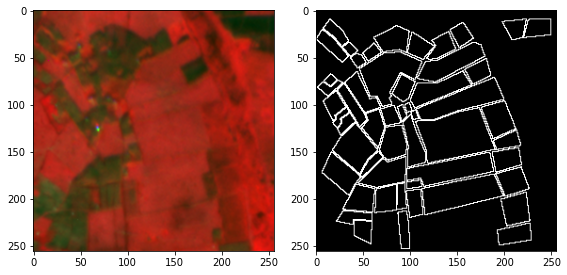

134


In [29]:
random.randint(0, len(augmented_files)) #sanity check
random_image = random.randint(0, len(augmented_files)-1)
#for i in range(len(augmented_files)):
#  random_image = i
show_image(X[random_image][:,:,0:3], y[random_image].reshape(IMG_WIDTH, IMG_HEIGHT))
print(random_image)

### Model Training

We decided to use U-Net as it has shown impressive results over multiple domains in image segmentation.
We will employ a ResNet34 backbone with our spatio-temporal U-Net model.

This uses our 24 channels (6 timestamps * 4 bands per timestamp) and generates the predicted field boundary per scene.

We will also use an 80:20 train:validation set split for model training.

Since this is a binary segmentation problem (field boundary or no field boundary), we will use the `binary cross_entropy` loss.

In [30]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [31]:
X = preprocess_input(X)

In [ ]:
#https://github.com/sustainlab-group/ParcelDelineation/blob/master/models/unet.py
def unet(pretrained_weights = None,input_size = (256,256,4)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return 

In [32]:
def learning_rate_scheduler(epoch):
    lr = 1e-4
    '''
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 150:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    '''
    print("Set Learning Rate : {}".format(lr))
    return lr

In [33]:
num_channels = 24 # was 24
input_shape = (256,256,num_channels)
batch_size = 4

For the model, we will make use of two key metrics: **Recall** and **F1-score**.

**Recall** evaluates how much of the field boundaries which were labelled were actually predicted as well while the **f1-score** combines the precision and recall by evaluating the harmonic mean.

**NOTE** that the recall is the more important metric for this case as we are mostly concerned about the retrieved field boundaries out of the labelled field boundaries.

In [34]:
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def f1(y_true, y_pred):
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall_   = recall(y_true, y_pred)
    return 2*((precision*recall_)/(precision+recall_+K.epsilon()))

In [35]:
#Use it for loading last good model
#Started with initial model of 18% whihc is model 1
#then I trained it again after making only 90 degreees rotations with 17% F1 which is model 3
#then I trained it again after making flipping and bluring and 45 degree rotations.

model = load_model(f"/content/drive/MyDrive/data/unet_modelv3.h5", custom_objects ={"recall":sm.metrics.Recall(threshold=0.5), "f1": f1})

In [ ]:
sm.set_framework('tf.keras')
sm.framework()
model = None 
model_unet = Unet(BACKBONE, encoder_weights='imagenet')
new_model = keras.models.Sequential()
new_model.add(Conv2D(3, (1,1), padding='same', activation='relu', input_shape=input_shape))
new_model.add(model_unet)
model = new_model 
#sm.metrics.FScore(beta=1)
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler(0)),
              metrics=[recall,f1])

85532672/85521592 [==============================] - 7s 0us/step
Set Learning Rate : 0.0001


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 3)       75        
                                                                 
 model_1 (Functional)        (None, None, None, 1)     24456154  
                                                                 
Total params: 24,456,229
Trainable params: 24,438,879
Non-trainable params: 17,350
_________________________________________________________________


In [37]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
tf.config.experimental_run_functions_eagerly(True)

In [40]:
history = model.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              steps_per_epoch = len(x_train)//batch_size,
              validation_steps = len(x_val)//batch_size,
              batch_size=batch_size, epochs=200)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/200
68/68 [==============================] - 26s 225ms/step - loss: 0.2117 - recall: 0.0517 - f1: 0.0565 - val_loss: 0.7969 - val_recall: 0.0107 - val_f1: 0.0208
Epoch 2/200
68/68 [==============================] - 18s 242ms/step - loss: 0.1535 - recall: 0.0083 - f1: 0.0161 - val_loss: 0.2345 - val_recall: 0.0362 - val_f1: 0.0669
Epoch 3/200
68/68 [==============================] - 16s 235ms/step - loss: 0.1341 - recall: 0.1227 - f1: 0.1918 - val_loss: 0.1830 - val_recall: 0.0634 - val_f1: 0.1093
Epoch 4/200
68/68 [==============================] - 16s 234ms/step - loss: 0.1199 - recall: 0.2652 - f1: 0.3700 - val_loss: 0.1578 - val_recall: 0.1269 - val_f1: 0.1976
Epoch 5/200
68/68 [==============================] - 16s 235ms/step - loss: 0.1055 - recall: 0.3552 - f1: 0.4563 - val_loss: 0.1533 - val_recall: 0.1904 - val_f1: 0.2707
Epoch 6/200
68/68 [==============================] - 16s 236ms/step - loss: 0.0998 - recall: 0.3840 - f1: 0.4842 - val_loss: 0.1554 - val_recall: 0.22

In [41]:
model.save(f"/content/drive/MyDrive/data/unet_modelv4.h5")

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [42]:
model = load_model(f"/content/drive/MyDrive/data/unet_modelv4.h5", custom_objects ={"recall":sm.metrics.Recall(threshold=0.5), "f1": f1})

### Loading test chips to run predictions

In [43]:
test_source_items = f"{dataset_id}/{dataset_id}_source_test"
test_tiles = [clean_string(s) for s in next(os.walk(test_source_items))[1]]

In [44]:
test_tile_ids = set()
for tile in test_tiles:
    test_tile_ids.add(tile.split('_')[0])

In [45]:
X_test = np.empty((len(test_tile_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS*len(timestamps)), dtype=np.float32)
i = 0
loaded_tiles = []
for tile_id in test_tile_ids:
    idx = 0
    for timestamp in timestamps:
        bd1 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B01.tif")
        bd1_array = bd1.read(1)
        bd2 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B02.tif")
        bd2_array = bd2.read(1)
        bd3 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B03.tif")
        bd3_array = bd3.read(1)
        bd4 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B04.tif")
        bd4_array = bd4.read(1)
        b01_norm = normalize(bd1_array)
        b02_norm = normalize(bd2_array)
        b03_norm = normalize(bd3_array)
        b04_norm = normalize(bd4_array)
        
        field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
        X_test[i][:,:,idx:idx+IMG_CHANNELS] = field
        idx+=IMG_CHANNELS
    loaded_tiles.append(str(tile_id).zfill(2)) #track order test tiles are loaded into X to make sure tile id matches 
    i+=1

In [46]:
predictions_dictionary = {}
for i in range(len(test_tile_ids)):
    model_pred = model.predict(np.expand_dims(X_test[i], 0))
    model_pred = model_pred[0]
    model_pred = (model_pred >= 0.5).astype(np.uint8)
    model_pred = model_pred.reshape(IMG_HEIGHT, IMG_WIDTH)
    predictions_dictionary.update([(str(loaded_tiles[i]), pd.DataFrame(model_pred))])

In [47]:
dfs = []
for key, value in predictions_dictionary.items():
    ftd = value.unstack().reset_index().rename(columns={'level_0': 'row', 'level_1': 'column', 0: 'label'})
    ftd['tile_row_column'] = f'Tile{key}_' + ftd['row'].astype(str) + '_' + ftd['column'].astype(str)
    ftd = ftd[['tile_row_column', 'label']]
    dfs.append(ftd)

sub = pd.concat(dfs)
sub

,tile_row_column,label
0,Tile03_0_0,0
1,Tile03_0_1,0
2,Tile03_0_2,0
3,Tile03_0_3,0
4,Tile03_0_4,0
...,...,...
65531,Tile07_255_251,0
65532,Tile07_255_252,0
65533,Tile07_255_253,0
65534,Tile07_255_254,0


In [48]:
sub.to_csv(f"/content/drive/MyDrive/data/harvest_sample_submission4.csv", index = False)